# FUZZY INFERENCE SYSTEM | MAMDANI & SUGENO


## Setup Depedencies

In [1]:
import os
import random
import pickle
import warnings
from datetime import datetime
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_fscore_support
)
from skimage import feature
from skimage.filters import threshold_otsu
import cv2
from scipy import stats

warnings.filterwarnings('ignore')

## FIS Env


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
class FuzzyAlzheimerSystem:
    """
    FUZZY INFERENCE SYSTEM - ALZHEIMER DETECTION | MAMDANI AND SUGENO MODEL
    1.   Import and Load Data
    2.   Preprocessing and Featuring Extraction
    3.   Dynamic Membership Function
    4.   Membership Utility
    5.   Rule Base for Mamdani
    6.   Rule Base for Sugeno
    7.   Inference Enggine
    8.   Weigthed Oversampling
    9.   Optimazation for Mamdani using Grid Search
    10.  Optimazation for Sugeno using Genetic Algorithm
    11.  Evaluation
    12.  Visualization
    13.  Save and Load All Model
    14.  Main (pipeline)
    """

    def __init__(self):
        self.class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
        self.class_mapping = {name: i for i, name in enumerate(self.class_names)}
        self.feature_ranges = {}
        self.membership_functions = {}
        self.rules_mamdani = []
        self.rules_sugeno = []
        self.output_mf_mamdani = {}
        self.sugeno_params = {}



    # ========================= DATASET LOADING =========================
    def check_dataset_structure(self, data_path):
        data_path = os.path.abspath(data_path)
        print("=" * 60)
        print(f"Base path: {data_path}")

        augmented_path = os.path.join(data_path, "AugmentedAlzheimerDataset")
        original_path = os.path.join(data_path, "OriginalDataset")

        structure_ok = True
        total_images = 0

        for dataset_name, dataset_path in [("AugmentedAlzheimerDataset", augmented_path),
                                           ("OriginalDataset", original_path)]:
            print(f"\nData : {dataset_name}:")
            if os.path.exists(dataset_path):
                print(f"Found: {dataset_path}")
                for class_name in self.class_names:
                    class_path = os.path.join(dataset_path, class_name)
                    if os.path.exists(class_path):
                        image_files = [
                            os.path.join(class_path, f) for f in os.listdir(class_path)
                            if f.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG', '.PNG'))
                        ]
                        count = len(image_files)
                        total_images += count
                        print(f"     {class_name}: {count} images")
                    else:
                        print(f"     Missing: {class_name}")
                        structure_ok = False
            else:
                print(f"   Not found: {dataset_path}")
                structure_ok = False

        print(f"\nTotal images found: {total_images}")
        print("=" * 60)

        if structure_ok and total_images > 0:
            print("Data Valid")
        else:
            print("error")

        return (structure_ok and total_images > 0)

    def load_dataset(self, data_path, use_augmented=True, use_original=True, limit_per_class=None):
        """
        Load dataset dari folder:
        X_images, y_labels, sources (Original/Augmented), filenames
        """
        data_path = os.path.abspath(data_path)
        print(f"\nLOADING DATASET")
        print("=" * 60)
        print(f"Base path: {data_path}")
        print(f"Use augmented: {use_augmented}")
        print(f"Use original: {use_original}")
        print(f"Limit per class: {limit_per_class}")

        X_images = []
        y_labels = []
        sources = []
        filenames = []

        datasets_to_load = []
        if use_original:
            datasets_to_load.append(("Original", os.path.join(data_path, "OriginalDataset")))
        if use_augmented:
            datasets_to_load.append(("Augmented", os.path.join(data_path, "AugmentedAlzheimerDataset")))

        class_counts = {name: {'Original': 0, 'Augmented': 0} for name in self.class_names}

        for dataset_type, dataset_path in datasets_to_load:
            if not os.path.exists(dataset_path):
                print(f"Skipping path{dataset_type}")
                continue

            print(f"\nLoading {dataset_type} dataset...")
            for class_name, class_id in self.class_mapping.items():
                class_folder = os.path.join(dataset_path, class_name)
                if not os.path.exists(class_folder):
                    print(f"{class_name}: folder not found")
                    continue

                image_files = [
                    os.path.join(class_folder, fname)
                    for fname in os.listdir(class_folder)
                    if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.JPG', '.JPEG', '.PNG'))
                ]
                image_files = sorted(image_files)

                if limit_per_class:
                    image_files = image_files[:limit_per_class]

                print(f"Loading {class_name}: {len(image_files)} images", end="")
                loaded_count = 0
                for img_file in image_files:
                    try:
                        image = cv2.imread(img_file)
                        if image is None or image.shape[0] < 50 or image.shape[1] < 50:
                            continue
                        image = cv2.resize(image, (224, 224))
                        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                        X_images.append(image)
                        y_labels.append(class_id)
                        sources.append(dataset_type)
                        filenames.append(f"{dataset_type}_{os.path.basename(img_file)}")

                        loaded_count += 1
                        class_counts[class_name][dataset_type] += 1
                    except Exception:
                        continue

                print(f" → {loaded_count} loaded")

        print(f"\n DATA AMOUNT SUMMARY:")
        print("=" * 40)
        total_loaded = len(X_images)
        print(f"Total images: {total_loaded}")
        for class_name in self.class_names:
            total_class = class_counts[class_name]['Original'] + class_counts[class_name]['Augmented']
            print(f"{class_name}: {total_class} total")
            print(f"  Original: {class_counts[class_name]['Original']}")
            print(f"  Augmented: {class_counts[class_name]['Augmented']}")

        return X_images, y_labels, sources, filenames






    # ========================= PREPROCESSING & FEATURE EXTRACTION =========================
    def preprocess_image(self, image):
        """Preprocessing: grayscale, blur, CLAHE, normalize to [0,1]"""
        if len(image.shape) == 3:
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        else:
            gray = image.copy()

        gray = cv2.GaussianBlur(gray, (3, 3), 0)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        gray = clahe.apply(gray)
        gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
        gray = gray.astype(np.float32) / 255.0
        return gray

    def extract_features(self, image):
        """
        Ekstraksi 9 fitur:
        1. mean
        2. variance
        3. entropy
        4. contrast
        5. homogeneity
        6. skewness
        7. kurtosis
        8. fractal_dim
        9. area_roi
        """
        if len(image.shape) == 3:
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        if image.max() > 1:
            image = image / 255.0

        features = {}
        features['mean'] = np.mean(image)
        features['variance'] = np.var(image)

        hist, _ = np.histogram((image * 255).astype(int), bins=256, range=(0, 255), density=True)
        hist = hist + 1e-9
        features['entropy'] = -np.sum(hist * np.log2(hist))

        try:
            img_uint8 = (image * 255).astype(np.uint8)
            glcm = feature.graycomatrix(img_uint8, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
            features['contrast'] = feature.graycoprops(glcm, 'contrast')[0, 0]
            features['homogeneity'] = feature.graycoprops(glcm, 'homogeneity')[0, 0]
        except Exception:
            features['contrast'] = 0.0
            features['homogeneity'] = 0.5

        flat_image = image.flatten()
        features['skewness'] = stats.skew(flat_image)
        features['kurtosis'] = stats.kurtosis(flat_image)

        features['fractal_dim'] = self.calculate_fractal_dimension(image)

        try:
            thresh = threshold_otsu(image)
            binary = image > thresh
            features['area_roi'] = np.sum(binary) / image.size
        except Exception:
            features['area_roi'] = 0.5

        return features

    def calculate_fractal_dimension(self, image, max_box_size=64):
        """Dimensi fraktal dengan box-counting"""
        try:
            thresh = threshold_otsu(image)
            binary = image > thresh
            scales = np.logspace(0.5, np.log10(max_box_size), num=8, dtype=int)
            scales = np.unique(scales)
            counts = []
            for scale in scales:
                h, w = binary.shape
                count = 0
                for i in range(0, h, scale):
                    for j in range(0, w, scale):
                        box = binary[i:i+scale, j:j+scale]
                        if box.size > 0 and np.any(box):
                            count += 1
                counts.append(count)
            if len(scales) > 1 and len(counts) > 1:
                valid_idx = np.array(counts) > 0
                if np.sum(valid_idx) > 1:
                    log_scales = np.log(scales[valid_idx])
                    log_counts = np.log(np.array(counts)[valid_idx])
                    coeffs = np.polyfit(log_scales, log_counts, 1)
                    return abs(coeffs[0])
            return 1.5
        except Exception:
            return 1.5

    def normalize_features(self, features_list, is_training=True):
        """
        Normalisasi fitur ke [0,1] dengan Min-Max Scaling.
        is_training=True → min/max di self.feature_ranges
        """
        df = pd.DataFrame(features_list)
        if is_training:
            self.feature_ranges = {}
            for col in df.columns:
                self.feature_ranges[col] = {
                    'min': df[col].min(),
                    'max': df[col].max()
                }
        normalized_df = df.copy()
        for col in df.columns:
            min_val = self.feature_ranges[col]['min']
            max_val = self.feature_ranges[col]['max']
            normalized_df[col] = (df[col] - min_val) / (max_val - min_val + 1e-9)
            normalized_df[col] = np.clip(normalized_df[col], 0, 1)
        return normalized_df






    # ========================= DYNAMIC MEMBERSHIP FUNCTIONS =========================
    def define_dynamic_membership_functions(self, features_df):
        """
        Setup definisi MF (Low/Medium/High) berdasarkan kuartil tiap fitur di DataFrame normalized.
        """
        print("\nDEFINING DYNAMIC MEMBERSHIP FUNCTIONS")
        print("=" * 50)
        self.membership_functions = {}
        for feat in features_df.columns:
            q1 = features_df[feat].quantile(0.25)
            q2 = features_df[feat].quantile(0.50)
            q3 = features_df[feat].quantile(0.75)
            if feat == 'skewness':
                # Skewness rentang [-1,1]: gunakan -1 dan 1 sebagai a_low, c_high
                a_low, b_low, c_low = -1.0, -1.0, q2
                a_med, b_med, c_med = q1, q2, q3
                a_high, b_high, c_high = q2, 1.0, 1.0
                self.membership_functions[feat] = {
                    'Low':    (a_low, b_low, c_low),
                    'Medium': (a_med, b_med, c_med),
                    'High':   (a_high, b_high, c_high)
                }
            else:
                a_low, b_low, c_low = 0.0, 0.0, q2
                a_med, b_med, c_med = q1, q2, q3
                a_high, b_high, c_high = q2, 1.0, 1.0
                self.membership_functions[feat] = {
                    'Low':    (a_low, b_low, c_low),
                    'Medium': (a_med, b_med, c_med),
                    'High':   (a_high, b_high, c_high)
                }
        # Output MF Mamdani: domain [0,3]
        self.output_mf_mamdani = {
            'NonDemented':      (0.0, 0.0, 0.75),
            'VeryMildDemented': (0.5, 1.0, 1.5),
            'MildDemented':     (1.25, 2.0, 2.75),
            'ModerateDemented': (2.25, 3.0, 3.0)
        }
        print("✅ Dynamic membership functions defined:")
        for feat in self.membership_functions:
            print(f"   - {feat}: {self.membership_functions[feat]}")






    # ========================= MEMBERSHIP UTILITY =========================
    def triangular_mf(self, x, a, b, c):
        """Fungsi keanggotaan triangular"""
        if isinstance(x, (int, float)):
            if x <= a or x >= c:
                return 0.0
            elif x == b:
                return 1.0
            elif a < x < b:
                return (x - a) / (b - a)
            else:
                return (c - x) / (c - b)
        else:
            result = np.zeros_like(x, dtype=float)
            mask1 = (x > a) & (x < b)
            mask2 = (x > b) & (x < c)
            mask3 = (x == b)
            result[mask1] = (x[mask1] - a) / (b - a)
            result[mask2] = (c - x[mask2]) / (c - b)
            result[mask3] = 1.0
            return result






    # ========================= COMPLETE RULE BASE MAMDANI =========================
    def create_rules_mamdani(self):
        """
        Rule base Mamdani dengan 9 featur
        """
        print("\nMAMDANI RULES")
        print("=" * 80)

        self.rules_mamdani = [
            # ----------- NON DEMENTED -----------
            {
                'antecedent': {
                    'mean': 'High', 'variance': 'Low', 'contrast': 'Low',
                    'homogeneity': 'High', 'entropy': 'Low', 'skewness': 'Zero',
                    'kurtosis': 'Low', 'fractal_dim': 'Low', 'area_roi': 'Large'
                },
                'consequent': 'NonDemented'
            },
            {
                'antecedent': {
                    'mean': 'High', 'variance': 'Medium', 'contrast': 'Low',
                    'homogeneity': 'High', 'entropy': 'Low', 'skewness': 'Zero',
                    'kurtosis': 'Medium', 'fractal_dim': 'Low', 'area_roi': 'Large'
                },
                'consequent': 'NonDemented'
            },
            {
                'antecedent': {
                    'mean': 'Medium', 'variance': 'Low', 'contrast': 'Low',
                    'homogeneity': 'High', 'entropy': 'Low', 'skewness': 'Zero',
                    'kurtosis': 'Low', 'fractal_dim': 'Medium', 'area_roi': 'Large'
                },
                'consequent': 'NonDemented'
            },

            # ----------- VERY MILD DEMENTED -----------
            {
                'antecedent': {
                    'mean': 'Medium', 'variance': 'Medium', 'contrast': 'Low',
                    'homogeneity': 'Medium', 'entropy': 'Medium', 'skewness': 'Positive',
                    'kurtosis': 'Medium', 'fractal_dim': 'Medium', 'area_roi': 'Medium'
                },
                'consequent': 'VeryMildDemented'
            },
            {
                'antecedent': {
                    'mean': 'High', 'variance': 'Medium', 'contrast': 'Medium',
                    'homogeneity': 'Medium', 'entropy': 'Medium', 'skewness': 'Positive',
                    'kurtosis': 'Medium', 'fractal_dim': 'Low', 'area_roi': 'Medium'
                },
                'consequent': 'VeryMildDemented'
            },
            {
                'antecedent': {
                    'mean': 'Medium', 'variance': 'Low', 'contrast': 'Medium',
                    'homogeneity': 'Medium', 'entropy': 'Medium', 'skewness': 'Zero',
                    'kurtosis': 'Low', 'fractal_dim': 'Medium', 'area_roi': 'Medium'
                },
                'consequent': 'VeryMildDemented'
            },

            # ----------- MILD DEMENTED -----------
            {
                'antecedent': {
                    'mean': 'Medium', 'variance': 'High', 'contrast': 'Medium',
                    'homogeneity': 'Low', 'entropy': 'High', 'skewness': 'Zero',
                    'kurtosis': 'High', 'fractal_dim': 'Medium', 'area_roi': 'Small'
                },
                'consequent': 'MildDemented'
            },
            {
                'antecedent': {
                    'mean': 'Low', 'variance': 'High', 'contrast': 'Medium',
                    'homogeneity': 'Low', 'entropy': 'High', 'skewness': 'Negative',
                    'kurtosis': 'High', 'fractal_dim': 'Medium', 'area_roi': 'Small'
                },
                'consequent': 'MildDemented'
            },
            {
                'antecedent': {
                    'mean': 'Medium', 'variance': 'Medium', 'contrast': 'High',
                    'homogeneity': 'Low', 'entropy': 'High', 'skewness': 'Positive',
                    'kurtosis': 'Medium', 'fractal_dim': 'High', 'area_roi': 'Medium'
                },
                'consequent': 'MildDemented'
            },

            # ----------- MODERATE DEMENTED -----------
            {
                'antecedent': {
                    'mean': 'Low', 'variance': 'High', 'contrast': 'High',
                    'homogeneity': 'Low', 'entropy': 'High', 'skewness': 'Negative',
                    'kurtosis': 'High', 'fractal_dim': 'High', 'area_roi': 'Small'
                },
                'consequent': 'ModerateDemented'
            },
            {
                'antecedent': {
                    'mean': 'Low', 'variance': 'High', 'contrast': 'Medium',
                    'homogeneity': 'Low', 'entropy': 'High', 'skewness': 'Negative',
                    'kurtosis': 'Medium', 'fractal_dim': 'High', 'area_roi': 'Small'
                },
                'consequent': 'ModerateDemented'
            },
            {
                'antecedent': {
                    'mean': 'Medium', 'variance': 'High', 'contrast': 'High',
                    'homogeneity': 'Low', 'entropy': 'High', 'skewness': 'Negative',
                    'kurtosis': 'High', 'fractal_dim': 'High', 'area_roi': 'Small'
                },
                'consequent': 'ModerateDemented'
            }
        ]







    # ========================= RULE BASE SUGENO =========================
    def create_rules_sugeno(self):
        """
        Buat rule base Sugeno dengan 3 fitur utama: mean, variance, contrast.
        Parameter diinisialisasi heuristik, dann dilanjutkna dengan dioptimasi oleh GA.
        """
        print("\nSUGENO RULES")
        print("=" * 40)
        fuzzy_sets = ['Low', 'Medium', 'High']
        self.rules_sugeno = []
        self.sugeno_params = {}
        rule_id = 0
        for mean_set in fuzzy_sets:
            for var_set in fuzzy_sets:
                for cont_set in fuzzy_sets:
                    rule = {
                        'antecedent': {
                            'mean': mean_set,
                            'variance': var_set,
                            'contrast': cont_set
                        },
                        'rule_id': rule_id
                    }
                    # Inisialisasi parameter linear heuristik
                    if mean_set == 'High' and var_set == 'Low' and cont_set == 'Low':
                        params = (2.0, -2.0, -1.5, 0.3)   # cenderung NonDemented
                    elif mean_set == 'Low' and var_set == 'High' and cont_set == 'High':
                        params = (-2.5, 2.5, 2.0, 2.7)    # cenderung ModerateDemented
                    elif mean_set == 'Medium' and var_set == 'Medium' and cont_set == 'Low':
                        params = (0.8, 0.5, -0.8, 1.0)    # cenderung VeryMildDemented
                    elif mean_set == 'Medium' and var_set == 'Medium' and cont_set == 'Medium':
                        params = (0.2, 1.2, 1.0, 1.8)     # cenderung MildDemented
                    else:
                        base_score = 0
                        if mean_set == 'Low':
                            base_score += 1.2
                        if var_set == 'High':
                            base_score += 1.0
                        if cont_set == 'High':
                            base_score += 0.8
                        params = (
                            np.random.uniform(-1.5, 1.5),
                            np.random.uniform(-1.5, 1.5),
                            np.random.uniform(-1.5, 1.5),
                            base_score + np.random.uniform(-0.3, 0.3)
                        )
                    self.sugeno_params[rule_id] = params
                    self.rules_sugeno.append(rule)
                    rule_id += 1







    # ========================= INFERENCE ENGINES =========================
    def fuzzify_input(self, feature_values):
        """Fuzzifikasi input menggunakan MF"""
        fuzzified = {}
        for feat_name, value in feature_values.items():
            if feat_name in self.membership_functions:
                fuzzified[feat_name] = {}
                for mf_name, (a, b, c) in self.membership_functions[feat_name].items():
                    if feat_name == 'skewness':
                        normalized_value = np.clip(value, -1, 1)
                        fuzzified[feat_name][mf_name] = self.triangular_mf(normalized_value, a, b, c)
                    else:
                        fuzzified[feat_name][mf_name] = self.triangular_mf(value, a, b, c)
        return fuzzified

    def evaluate_rules_mamdani(self, fuzzified_inputs):
        """
        Evaluasi rules Mamdani → agregasi → defuzzifikasi (Mean of Maxima)
        """
        rule_outputs = []
        for rule in self.rules_mamdani:
            alphas = []
            for feat_name, fuzzy_set in rule['antecedent'].items():
                if feat_name in fuzzified_inputs and fuzzy_set in fuzzified_inputs[feat_name]:
                    alphas.append(fuzzified_inputs[feat_name][fuzzy_set])
            if alphas:
                alpha = min(alphas)
                rule_outputs.append((alpha, rule['consequent']))

        y_domain = np.linspace(0, 3, 1000)
        aggregated_output = np.zeros_like(y_domain)

        for alpha, consequent_class in rule_outputs:
            if alpha > 0:
                a, b, c = self.output_mf_mamdani[consequent_class]
                mf_values = self.triangular_mf(y_domain, a, b, c)
                clipped_mf = np.minimum(mf_values, alpha)
                aggregated_output = np.maximum(aggregated_output, clipped_mf)

        if np.sum(aggregated_output) > 0:
            max_val = aggregated_output.max()
            indices = np.where(np.isclose(aggregated_output, max_val))[0]
            centroid_mom = np.mean(y_domain[indices])
            return centroid_mom, y_domain, aggregated_output
        else:
            return 0.0, y_domain, aggregated_output

    def evaluate_rules_sugeno(self, fuzzified_inputs, feature_values):
        """
        Evaluasi rules Sugeno → weighted average
        """
        alphas = []
        outputs = []
        for rule in self.rules_sugeno:
            rule_alphas = []
            for feat_name, fuzzy_set in rule['antecedent'].items():
                if feat_name in fuzzified_inputs and fuzzy_set in fuzzified_inputs[feat_name]:
                    rule_alphas.append(fuzzified_inputs[feat_name][fuzzy_set])
            if rule_alphas:
                alpha = min(rule_alphas)
                rule_id = rule['rule_id']
                a1, a2, a3, b = self.sugeno_params[rule_id]
                x_mean = feature_values.get('mean', 0)
                x_var = feature_values.get('variance', 0)
                x_cont = feature_values.get('contrast', 0)
                output = a1 * x_mean + a2 * x_var + a3 * x_cont + b
                alphas.append(alpha)
                outputs.append(output)
        alphas = np.array(alphas)
        outputs = np.array(outputs)
        if np.sum(alphas) > 0:
            final_output = np.sum(alphas * outputs) / np.sum(alphas)
        else:
            final_output = 0.0
        return final_output

    def predict_mamdani(self, features):
        """Prediksi kelas & output Mamdani"""
        fuzzified = self.fuzzify_input(features)
        centroid, _, _ = self.evaluate_rules_mamdani(fuzzified)
        predicted_class = int(round(np.clip(centroid, 0, 3)))
        return predicted_class, centroid

    def predict_sugeno(self, features):
        """Prediksi kelas & output Sugeno"""
        fuzzified = self.fuzzify_input(features)
        output = self.evaluate_rules_sugeno(fuzzified, features)
        predicted_class = int(round(np.clip(output, 0, 3)))
        return predicted_class, output







    # ========================= WEIGHTED OVERSAMPLING =========================
    @staticmethod
    def balance_classes_weighted(X_train, y_train, sources_train, weight_original=2, weight_augmented=1):
        """
        Weighted oversampling:
        - Setiap instance original (sources_train[i] == 'Original') muncul 'weight_original' kali dalam kandidat.
        - Setiap instance augmented muncul 'weight_augmented' kali.
        - Dari kandidat random sampling hingga masing-masing kelas mencapai target_count.

        Weighted oversampling digunakan untuk mengatasi imbalanced data yang extream pada dataset yang kami gunakan
        """
        print("\nWEIGHTED OVERSAMPLING (Imbalance antara Original weight > Augmented)")
        counts = Counter(y_train)
        max_count = max(counts.values())
        X_balanced, y_balanced = [], []

        # Klasifikasikan indeks berdasarkan kelas
        indices_per_class = {cls: [] for cls in set(y_train)}
        for idx, label in enumerate(y_train):
            indices_per_class[label].append(idx)

        for class_id, idxs in indices_per_class.items():
            # Buat daftar kandidat dengan bobot
            weighted_candidates = []
            for i in idxs:
                if sources_train[i] == 'Original':
                    weighted_candidates += [i] * weight_original
                else:
                    weighted_candidates += [i] * weight_augmented

            # Jika weighted_candidates kosong, skip
            if not weighted_candidates:
                continue

            # Ambil semua sampel unik minimal satu kali
            for i in idxs:
                X_balanced.append(X_train[i])
                y_balanced.append(y_train[i])

            # Tambah oversampling hingga jumlah total = max_count
            n_need = max_count - len(idxs)
            if n_need > 0:
                chosen = list(np.random.choice(weighted_candidates, size=n_need, replace=True))
                for i in chosen:
                    X_balanced.append(X_train[i])
                    y_balanced.append(y_train[i])

        print(f"  Original distribution: {counts}")
        new_counts = Counter(y_balanced)
        print(f"  New balanced distribution: {new_counts}")
        return X_balanced, y_balanced







    # ========================= OPTIMIZATION (MAMDANI - GRID SEARCH) =========================
    def grid_search_optimization_mamdani(self, X_train, y_train, X_val, y_val):
        """
        Extended Grid Search:
        - centers = np.linspace(0.2,0.8,7), widths = np.linspace(0.1,0.5,5)
        - iterasi = 200
        """
        print("\n GRID SEARCH OPTIMIZATION (MAMDANI)")
        print("=" * 50)
        best_accuracy = 0
        best_config = None
        original_mf = {feat: self.membership_functions[feat].copy() for feat in self.membership_functions}
        key_features = ['mean', 'variance', 'contrast', 'homogeneity', 'entropy', 'area_roi']

        centers = np.linspace(0.2, 0.8, 7)
        widths = np.linspace(0.1, 0.5, 5)
        n_iterations = 200

        for iteration in range(n_iterations):
            config = {}
            for feat in key_features:
                center = float(np.random.choice(centers))
                width = float(np.random.choice(widths))
                low_c = max(center - width, 0.0)
                med_a = max(center - width / 2, 0.0)
                med_c = min(center + width / 2, 1.0)
                high_a = min(center + width, 1.0)
                config[feat] = {
                    'Low':    (0.0, 0.0, low_c),
                    'Medium': (med_a, center, med_c),
                    'High':   (high_a, 1.0, 1.0)
                }

            # Update membership_functions sementara
            for feat in key_features:
                self.membership_functions[feat] = config[feat]

            # Evaluasi pada validation set
            preds = [self.predict_mamdani(feats)[0] for feats in X_val]
            acc = np.mean(np.array(preds) == np.array(y_val))
            if acc > best_accuracy:
                best_accuracy = acc
                best_config = {feat: config[feat].copy() for feat in key_features}
                print(f"  + Iter {iteration+1}/{n_iterations}: New best acc = {best_accuracy:.4f}")

            # Kembalikan MF asli
            for feat in key_features:
                self.membership_functions[feat] = original_mf[feat]

        # Terapkan konfigurasi terbaik
        if best_config is not None:
            for feat in key_features:
                self.membership_functions[feat] = best_config[feat]
        print(f"Best accuracy: {best_accuracy:.4f}")
        return best_accuracy, best_config







    # ========================= OPTIMIZATION (SUGENO - GENETIC ALGORITHM) =========================
    def genetic_algorithm_sugeno(self, X_train, y_train, X_val, y_val,
                                 generations=100, population_size=50):
        """
        Extended GA:
        - Generations = 100, Population = 50
        - Tournament size = 5, Arithmetic Crossover, Mutasi adaptif
        """
        print(f"\nGENETIC ALGORITHM OPTIMIZATION (SUGENO)")
        print("=" * 50)
        print(f"Generations: {generations}, Population: {population_size}")
        n_rules = len(self.rules_sugeno)

        # Inisialisasi populasi
        population = []
        for _ in range(population_size):
            individual = {}
            for rule_id in range(n_rules):
                individual[rule_id] = (
                    np.random.uniform(-2, 2),
                    np.random.uniform(-2, 2),
                    np.random.uniform(-2, 2),
                    np.random.uniform(0, 3)
                )
            population.append(individual)

        best_fitness_history = []
        for gen in range(generations):
            fitness_scores = []
            for individual in population:
                original_params = self.sugeno_params.copy()
                self.sugeno_params = individual

                preds = [self.predict_sugeno(f)[0] for f in X_val]
                fitness = np.mean(np.array(preds) == np.array(y_val))
                fitness_scores.append(fitness)
                self.sugeno_params = original_params

            best_fit = max(fitness_scores)
            best_fitness_history.append(best_fit)
            if (gen + 1) % 10 == 0 or gen == 0:
                print(f"  – Generation {gen+1}/{generations}, Best fitness: {best_fit:.4f}")

            # Selection (Tournament)
            new_population = []
            for _ in range(population_size):
                tournament_size = 5
                candidates = np.random.choice(range(population_size), size=tournament_size, replace=False)
                candidate_fitness = [fitness_scores[i] for i in candidates]
                winner_idx = candidates[np.argmax(candidate_fitness)]
                new_population.append(population[winner_idx].copy())

            # Arithmetic Crossover
            for i in range(0, population_size - 1, 2):
                if np.random.random() < 0.9:
                    parent1 = new_population[i]
                    parent2 = new_population[i + 1]
                    child1, child2 = {}, {}
                    for rule_id in range(n_rules):
                        alpha = np.random.rand()
                        p1 = np.array(parent1[rule_id])
                        p2 = np.array(parent2[rule_id])
                        c1 = alpha * p1 + (1 - alpha) * p2
                        c2 = (1 - alpha) * p1 + alpha * p2
                        child1[rule_id] = tuple(c1)
                        child2[rule_id] = tuple(c2)
                    new_population[i] = child1
                    new_population[i + 1] = child2

            # Adaptif Mutation
            for i in range(population_size):
                if np.random.random() < 0.2:
                    individual = new_population[i]
                    rule_mut = np.random.randint(n_rules)
                    params = list(individual[rule_mut])
                    noise_scale = 0.5 if fitness_scores[i] < 0.3 else 0.1
                    idx_param = np.random.randint(4)
                    params[idx_param] += np.random.normal(0, noise_scale)
                    if idx_param < 3:
                        params[idx_param] = np.clip(params[idx_param], -2, 2)
                    else:
                        params[idx_param] = np.clip(params[idx_param], 0, 3)
                    individual[rule_mut] = tuple(params)
                    new_population[i] = individual

            population = new_population

        # Terapkan individu terbaik
        best_idx = np.argmax(fitness_scores)
        self.sugeno_params = population[best_idx]
        print(f"Best fitness akhir: {best_fitness_history[-1]:.4f}")
        return best_fitness_history, self.sugeno_params






    # ========================= EVALUATION =========================
    def evaluate_model(self, X_test, y_test, model_type='mamdani'):
        """
        Evaluasi pada data test:
        akurasi, predictions, raw_outputs, confusion_matrix, classification_report
        """
        predictions = []
        raw_outputs = []
        for features in X_test:
            if model_type == 'mamdani':
                pred, raw = self.predict_mamdani(features)
            else:
                pred, raw = self.predict_sugeno(features)
            predictions.append(pred)
            raw_outputs.append(raw)
        predictions = np.array(predictions)
        y_true = np.array(y_test)
        accuracy = np.mean(predictions == y_true)
        cm = confusion_matrix(y_true, predictions, labels=[0, 1, 2, 3])
        report = classification_report(y_true, predictions, target_names=self.class_names, zero_division=0)
        return {
            'accuracy': accuracy,
            'predictions': predictions,
            'raw_outputs': raw_outputs,
            'confusion_matrix': cm,
            'classification_report': report
        }






    # ========================= VISUALIZATION =========================
    def plot_membership_functions(self):
        """Plot semua input MF (dynamic) dan output MF Mamdani"""
        print("\nPLOTTING MEMBERSHIP FUNCTIONS")
        print("=" * 40)
        fig, axes = plt.subplots(3, 3, figsize=(18, 12))
        axes = axes.flatten()
        feature_names = list(self.membership_functions.keys())
        for i, feat_name in enumerate(feature_names):
            ax = axes[i]
            if feat_name == 'skewness':
                x_vals = np.linspace(-1, 1, 500)
                ax.set_xlim(-1, 1)
                ax.set_xlabel('Skewness Value')
            else:
                x_vals = np.linspace(0, 1, 500)
                ax.set_xlim(0, 1)
                ax.set_xlabel('Normalized Value')
            colors = ['blue', 'orange', 'green']
            for j, (mf_name, (a, b, c)) in enumerate(self.membership_functions[feat_name].items()):
                y_vals = self.triangular_mf(x_vals, a, b, c)
                ax.plot(x_vals, y_vals, label=mf_name, linewidth=2, color=colors[j % 3])
            ax.set_ylim(0, 1.1)
            ax.set_ylabel('Membership Degree')
            ax.set_title(f'MF untuk {feat_name.capitalize()}')
            ax.legend()
            ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.suptitle('INPUT MEMBERSHIP FUNCTIONS (DINAMIS)', fontsize=16, y=1.02)
        plt.show()

        plt.figure(figsize=(12, 6))
        y_domain = np.linspace(0, 3, 500)
        colors = ['blue', 'orange', 'green', 'red']
        for i, (class_name, (a, b, c)) in enumerate(self.output_mf_mamdani.items()):
            y_vals = self.triangular_mf(y_domain, a, b, c)
            plt.plot(y_domain, y_vals, label=class_name, linewidth=3, color=colors[i])
            plt.annotate(f'({a:.2f}, {b:.2f}, {c:.2f})', xy=(b, 1), xytext=(b, 1.1),
                         ha='center', fontsize=10, color=colors[i])
        plt.xlim(0, 3)
        plt.ylim(0, 1.2)
        plt.xlabel('Output Domain [0-3]')
        plt.ylabel('Membership Degree')
        plt.title('OUTPUT MEMBERSHIP FUNCTIONS (MAMDANI)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def plot_rules_table(self):
        """Cetak tabel rule Mamdani dan Sugeno (sample)"""
        print("\nDISPLAYING RULES TABLES")
        print("=" * 60)
        # Mamdani rules
        print("\nMAMDANI RULES:")
        mamdani_data = []
        for i, rule in enumerate(self.rules_mamdani):
            row = {'No': i + 1}
            for feat, val in rule['antecedent'].items():
                row[feat] = val
            row['Consequent'] = rule['consequent']
            mamdani_data.append(row)
        df_mamdani = pd.DataFrame(mamdani_data)
        print(df_mamdani.to_string(index=False))

        # Sugeno rules (1st 12)
        print("\nSUGENO RULES (Sample - First 12):")
        sugeno_data = []
        for i, rule in enumerate(self.rules_sugeno[:12]):
            row = {'No': i + 1}
            for feat, val in rule['antecedent'].items():
                row[feat] = val
            a1, a2, a3, b = self.sugeno_params[rule['rule_id']]
            row['Linear Function'] = f"y = {a1:.2f}*mean + {a2:.2f}*var + {a3:.2f}*cont + {b:.2f}"
            sugeno_data.append(row)
        df_sugeno = pd.DataFrame(sugeno_data)
        print(df_sugeno.to_string(index=False))

    def plot_comprehensive_results(self, results_mamdani, results_sugeno,
                                   baseline_mamdani=None, baseline_sugeno=None):
        """Plot perbandingan akurasi, confusion matrix, per-class accuracy, distrib error"""
        print("\nPLOTTING FINAL RESULTS")
        print("=" * 50)
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        # Accuracy comparison
        if baseline_mamdani and baseline_sugeno:
            methods = ['Baseline\nMamdani', 'Final\nMamdani', 'Baseline\nSugeno', 'Final\nSugeno']
            accuracies = [baseline_mamdani['accuracy'], results_mamdani['accuracy'],
                          baseline_sugeno['accuracy'], results_sugeno['accuracy']]
            colors = ['lightblue', 'blue', 'lightgreen', 'green']
        else:
            methods = ['Mamdani', 'Sugeno']
            accuracies = [results_mamdani['accuracy'], results_sugeno['accuracy']]
            colors = ['blue', 'green']
        bars = axes[0, 0].bar(methods, accuracies, color=colors)
        axes[0, 0].set_title('Accuracy Comparison')
        axes[0, 0].set_ylabel('Accuracy')
        axes[0, 0].set_ylim(0, 1)
        for bar, acc in zip(bars, accuracies):
            h = bar.get_height()
            axes[0, 0].text(bar.get_x() + bar.get_width()/2., h + 0.01,
                            f'{acc:.3f}', ha='center', va='bottom')

        # Confusion Matrices
        sns.heatmap(results_mamdani['confusion_matrix'], annot=True, fmt='d',
                    cmap='Blues', ax=axes[0, 1],
                    xticklabels=['ND', 'VMD', 'MD', 'MOD'],
                    yticklabels=['ND', 'VMD', 'MD', 'MOD'])
        axes[0, 1].set_title(f'Mamdani CM - Acc: {results_mamdani["accuracy"]:.3f}')

        sns.heatmap(results_sugeno['confusion_matrix'], annot=True, fmt='d',
                    cmap='Greens', ax=axes[0, 2],
                    xticklabels=['ND', 'VMD', 'MD', 'MOD'],
                    yticklabels=['ND', 'VMD', 'MD', 'MOD'])
        axes[0, 2].set_title(f'Sugeno CM - Acc: {results_sugeno["accuracy"]:.3f}')

        # Per-Class Accuracy
        acc_m = []
        acc_s = []
        for i in range(len(self.class_names)):
            acc_m.append(
                np.diag(results_mamdani['confusion_matrix'])[i] /
                (np.sum(results_mamdani['confusion_matrix'], axis=1)[i] + 1e-9)
            )
            acc_s.append(
                np.diag(results_sugeno['confusion_matrix'])[i] /
                (np.sum(results_sugeno['confusion_matrix'], axis=1)[i] + 1e-9)
            )
        x = np.arange(len(self.class_names))
        width = 0.35
        axes[1, 0].bar(x - width/2, acc_m, width, label='Mamdani', color='blue', alpha=0.7)
        axes[1, 0].bar(x + width/2, acc_s, width, label='Sugeno', color='green', alpha=0.7)
        axes[1, 0].set_ylabel('Accuracy')
        axes[1, 0].set_title('Per-Class Accuracy')
        axes[1, 0].set_xticks(x)
        axes[1, 0].set_xticklabels(['ND', 'VMD', 'MD', 'MOD'])
        axes[1, 0].legend()
        axes[1, 0].set_ylim(0, 1)

        # Error Distribution
        error_mamdani = np.array(results_mamdani['raw_outputs']) - np.array(results_mamdani['predictions'])
        axes[1, 1].hist(error_mamdani, bins=15, alpha=0.7, color='blue', label='Mamdani')
        axes[1, 1].set_xlabel('Raw Output - Predicted Class')
        axes[1, 1].set_ylabel('Frequency')
        axes[1, 1].set_title('Mamdani Error Distribution')
        axes[1, 1].legend()

        error_sugeno = np.array(results_sugeno['raw_outputs']) - np.array(results_sugeno['predictions'])
        axes[1, 2].hist(error_sugeno, bins=15, alpha=0.7, color='green', label='Sugeno')
        axes[1, 2].set_xlabel('Raw Output - Predicted Class')
        axes[1, 2].set_ylabel('Frequency')
        axes[1, 2].set_title('Sugeno Error Distribution')
        axes[1, 2].legend()

        plt.tight_layout()
        plt.show()






    # ========================= SAVE & LOAD MODEL =========================
    def save_model(self, filepath):
        """Simpan model lengkap ke file pickle"""
        model_data = {
            'feature_ranges': self.feature_ranges,
            'membership_functions': self.membership_functions,
            'rules_mamdani': self.rules_mamdani,
            'rules_sugeno': self.rules_sugeno,
            'output_mf_mamdani': self.output_mf_mamdani,
            'sugeno_params': self.sugeno_params,
            'class_names': self.class_names,
            'save_time': datetime.now().isoformat(),
            'version': '1.2_weighted'
        }
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved: {filepath}")

    def load_model(self, filepath):
        """Muat model dari file pickle"""
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        self.feature_ranges = model_data['feature_ranges']
        self.membership_functions = model_data['membership_functions']
        self.rules_mamdani = model_data['rules_mamdani']
        self.rules_sugeno = model_data['rules_sugeno']
        self.output_mf_mamdani = model_data['output_mf_mamdani']
        self.sugeno_params = model_data['sugeno_params']
        self.class_names = model_data['class_names']
        print(f"   Save time: {model_data.get('save_time', 'Unknown')}")
        print(f"   Version: {model_data.get('version', 'Unknown')}")







    # ========================= MAIN WORKFLOW =========================
    def run_complete_experiment(self, data_path, use_augmented=True, use_original=True,
                                limit_per_class=None, optimize_parameters=True):
        """
        Jalankan eksperimen lengkap:
        1. Cek struktur dataset
        2. Load dataset (X_images, y_labels, sources)
        3. Preprocessing & extract features → X_features_raw
        4. Split data (stratified) → train_idx, val_idx, test_idx
        5. Normalize fitur berdasarkan train
        6. Weighted oversampling kelas minor (X_train, y_train)
        7. Define dynamic MF (df_train)
        8. Buat rules Mamdani & Sugeno
        9. Baseline evaluation
        10. Optimasi parameter (Grid Search & GA)
        11. Final evaluation test set
        12. Visualisasi & laporan
        13. Simpan model
        """
        print("=" * 100)
        print("FUZZY INFERENCE SYSTEM FOR ALZHEIMER CLASSIFICATION")
        print("=" * 100)

        # 1. Check dataset
        if not self.check_dataset_structure(data_path):
            print("Dataset validation failed!")
            return None

        # 2. Load dataset
        X_images, y_labels, sources, filenames = self.load_dataset(
            data_path, use_augmented, use_original, limit_per_class)
        if len(X_images) == 0:
            print("No images loaded!")
            return None

        # 3. Preprocessing & Extract Features
        print(f"\nPREPROCESSING & FEATURE EXTRACTION")
        print("=" * 60)
        X_processed = [self.preprocess_image(img) for img in X_images]
        X_features_raw = []
        for i, img in enumerate(X_processed):
            features = self.extract_features(img)
            X_features_raw.append(features)
            if (i + 1) % 200 == 0:
                print(f"  Processed {i+1}/{len(X_processed)} images")

        # 4. Split data (stratified)
        print(f"\nDATA SPLITTING")
        print("=" * 30)
        indices_per_class = {i: [] for i in range(len(self.class_names))}
        for idx, label in enumerate(y_labels):
            indices_per_class[label].append(idx)

        train_idx, val_idx, test_idx = [], [], []
        for class_id, idxs in indices_per_class.items():
            random.shuffle(idxs)
            n_class = len(idxs)
            n_train = max(1, int(n_class * 0.7))
            n_val = max(1, int(n_class * 0.15))
            train_idx.extend(idxs[:n_train])
            val_idx.extend(idxs[n_train:n_train + n_val])
            test_idx.extend(idxs[n_train + n_val:])

        X_train_raw = [X_features_raw[i] for i in train_idx]
        y_train = [y_labels[i] for i in train_idx]
        sources_train = [sources[i] for i in train_idx]

        X_val_raw = [X_features_raw[i] for i in val_idx]
        y_val = [y_labels[i] for i in val_idx]

        X_test_raw = [X_features_raw[i] for i in test_idx]
        y_test = [y_labels[i] for i in test_idx]

        print(f"Train: {len(X_train_raw)}, Val: {len(X_val_raw)}, Test: {len(X_test_raw)}")

        # 5. Normalize fitur
        print("\nNORMALIZING FEATURES BASED ON TRAIN SET")
        df_train = self.normalize_features(X_train_raw, is_training=True)
        df_val = self.normalize_features(X_val_raw, is_training=False)
        df_test = self.normalize_features(X_test_raw, is_training=False)

        # 6. Convert DataFrame ke list of dict untuk inference
        X_train = [{col: df_train.iloc[i][col] for col in df_train.columns} for i in range(len(df_train))]
        X_val = [{col: df_val.iloc[i][col] for col in df_val.columns} for i in range(len(df_val))]
        X_test = [{col: df_test.iloc[i][col] for col in df_test.columns} for i in range(len(df_test))]

        # 7. Weighted Oversampling kelas minor
        X_train, y_train = self.balance_classes_weighted(X_train, y_train, sources_train,
                                                         weight_original=2, weight_augmented=1)

        # 8. Define dynamic MF
        self.define_dynamic_membership_functions(df_train)

        # 9. Create rule bases
        self.create_rules_mamdani()
        self.create_rules_sugeno()

        # 10. Baseline evaluation tanpa optimasi
        print(f"\nBASELINE EVALUATION (tanpa optimasi)")
        baseline_mamdani = self.evaluate_model(X_val, y_val, model_type='mamdani')
        baseline_sugeno = self.evaluate_model(X_val, y_val, model_type='sugeno')
        print(f"Baseline Mamdani Acc: {baseline_mamdani['accuracy']:.4f}")
        print(f"Baseline Sugeno  Acc: {baseline_sugeno['accuracy']:.4f}")

        # 11. Optimasi parameter (opsional)
        optimization_success = False
        if optimize_parameters:
            best_acc_m, best_mf_config = self.grid_search_optimization_mamdani(
                X_train, y_train, X_val, y_val)
            best_fitness_history, best_sugeno_params = self.genetic_algorithm_sugeno(
                X_train, y_train, X_val, y_val, generations=100, population_size=50)
            optimization_success = True
        else:
            best_acc_m = best_mf_config = best_fitness_history = best_sugeno_params = None

        # 12. Final evaluation pada test set
        print(f"\nFINAL EVALUATION (data test)")
        final_mamdani = self.evaluate_model(X_test, y_test, model_type='mamdani')
        final_sugeno = self.evaluate_model(X_test, y_test, model_type='sugeno')
        print(f"Final Mamdani Acc: {final_mamdani['accuracy']:.4f}")
        print(f"Final Sugeno  Acc:  {final_sugeno['accuracy']:.4f}")

        # 13. Visualisasi hasil komprehensif
        if optimize_parameters:
            self.plot_comprehensive_results(final_mamdani, final_sugeno,
                                            baseline_mamdani, baseline_sugeno)
        else:
            self.plot_comprehensive_results(final_mamdani, final_sugeno)

        # 14. Final report
        print(f"\nFINAL REPORT")
        print("=" * 30)
        best_method = "Mamdani" if final_mamdani['accuracy'] > final_sugeno['accuracy'] else "Sugeno"
        best_accuracy = max(final_mamdani['accuracy'], final_sugeno['accuracy'])
        mam_impr = final_mamdani['accuracy'] - baseline_mamdani['accuracy'] if optimize_parameters else 0
        sug_impr = final_sugeno['accuracy'] - baseline_sugeno['accuracy'] if optimize_parameters else 0

        print(f"PERFORMANCE SUMMARY:")
        print(f"   Total images: {len(X_train_raw) + len(X_val_raw) + len(X_test_raw)}")
        print(f"   Features extracted: 9 features")
        print(f"   Mamdani rules: {len(self.rules_mamdani)}")
        print(f"   Sugeno rules: {len(self.rules_sugeno)}")
        print(f"   Baseline Mamdani: {baseline_mamdani['accuracy']:.4f}")
        print(f"   Final Mamdani:    {final_mamdani['accuracy']:.4f} ({mam_impr:+.4f})")
        print(f"   Baseline Sugeno:  {baseline_sugeno['accuracy']:.4f}")
        print(f"   Final Sugeno:     {final_sugeno['accuracy']:.4f} ({sug_impr:+.4f})")
        print(f"   Best Method: {best_method} ({best_accuracy:.4f})")
        print(f"   Optimization: {' Success' if optimization_success else ' Skipped/Failed'}")
        print(f"\nCLASSIFICATION REPORTS:")
        print(f"\nMAMDANI:\n{final_mamdani['classification_report']}")
        print(f"\nSUGENO:\n{final_sugeno['classification_report']}")

        # 15. Simpan model
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        model_filename = f"fuzzy_alzheimer_weighted_{timestamp}.pkl"
        self.save_model(model_filename)

        return {
            'baseline_results': {'mamdani': baseline_mamdani, 'sugeno': baseline_sugeno},
            'final_results': {'mamdani': final_mamdani, 'sugeno': final_sugeno},
            'optimization_success': optimization_success,
            'best_method': best_method,
            'best_accuracy': best_accuracy,
            'model_filename': model_filename,
            'fuzzy_system': self,
            'X_test': X_test,
            'y_test': y_test
        }



## Utility



In [4]:
def quick_test_single_image(fuzzy_system, image_path):
    """Test single image dengan model"""
    try:
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (224, 224))
        processed = fuzzy_system.preprocess_image(image)
        features = fuzzy_system.extract_features(processed)
        normalized_features = {}
        for feat_name, value in features.items():
            if feat_name in fuzzy_system.feature_ranges:
                min_val = fuzzy_system.feature_ranges[feat_name]['min']
                max_val = fuzzy_system.feature_ranges[feat_name]['max']
                normalized_features[feat_name] = (value - min_val) / (max_val - min_val + 1e-9)
                normalized_features[feat_name] = np.clip(normalized_features[feat_name], 0, 1)
            else:
                normalized_features[feat_name] = value
        pred_mamdani, conf_mamdani = fuzzy_system.predict_mamdani(normalized_features)
        pred_sugeno, conf_sugeno = fuzzy_system.predict_sugeno(normalized_features)
        print(f"Image: {image_path}")
        print(f"Mamdani:  {fuzzy_system.class_names[pred_mamdani]} (confidence: {conf_mamdani:.3f})")
        print(f"Sugeno:   {fuzzy_system.class_names[pred_sugeno]} (confidence: {conf_sugeno:.3f})")
        if pred_mamdani == pred_sugeno:
            print(f"Both methods agree: {fuzzy_system.class_names[pred_mamdani]}")
        else:
            print(f" Methods disagree!")
        return {
            'mamdani': {'prediction': pred_mamdani, 'confidence': conf_mamdani},
            'sugeno': {'prediction': pred_sugeno, 'confidence': conf_sugeno}
        }
    except Exception as e:
        print(f"Error processing image: {e}")
        return None

In [5]:
def run_alzheimer_experiment(data_path, limit_per_class=None, optimize=True):
    """ Wrapper """
    fuzzy_system = FuzzyAlzheimerSystem()
    results = fuzzy_system.run_complete_experiment(
        data_path=data_path,
        use_augmented=True,
        use_original=True,
        limit_per_class=limit_per_class,
        optimize_parameters=optimize
    )
    return results


## Result Display Setup

In [6]:
class EnhancedMetricsDisplay:
    """
    ENHANCED METRICS & VISUALIZATION DISPLAY
    Menampilkan metrik: Precision, Recall, F1, Confusion Matrix, dan Dashboard lengkap.
    """

    def __init__(self, fuzzy_system):
        self.fuzzy_system = fuzzy_system
        self.class_names = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']

    def display_detailed_metrics(self, results_mamdani, results_sugeno, y_test):
        """
        Tampilkan metrik performa:
        - Accuracy
        - Precision, Recall, F1-Score per kelas
        - Confusion Matrix (teks + heatmap)
        - Classification Report
        """
        print("\n" + "=" * 80)
        print("DETAILED PERFORMANCE METRICS")
        print("=" * 80)

        pred_mamdani = results_mamdani['predictions']
        pred_sugeno = results_sugeno['predictions']

        self._display_model_metrics("MAMDANI", y_test, pred_mamdani)
        self._display_model_metrics("SUGENO", y_test, pred_sugeno)
        self._display_comparison_summary(results_mamdani, results_sugeno)

    def _display_model_metrics(self, model_name, y_true, y_pred):
        """Tampilan metrik detail untuk satu model"""
        print(f"\n{model_name} MODEL METRICS:")
        print("-" * 50)

        accuracy = np.mean(np.array(y_true) == np.array(y_pred))
        print(f"ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)")

        precision, recall, f1, support = precision_recall_fscore_support(
            y_true, y_pred, average=None, zero_division=0
        )

        print(f"\nPER-CLASS METRICS:")
        print(f"{'Class':<20} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<8}")
        print("-" * 65)
        for i, class_name in enumerate(self.class_names):
            if i < len(precision):
                print(f"{class_name:<20} {precision[i]:<10.4f} {recall[i]:<10.4f} {f1[i]:<10.4f} {support[i]:<8}")

        precision_macro = np.mean(precision)
        recall_macro = np.mean(recall)
        f1_macro = np.mean(f1)
        precision_weighted = np.average(precision, weights=support)
        recall_weighted = np.average(recall, weights=support)
        f1_weighted = np.average(f1, weights=support)

        print("-" * 65)
        print(f"{'Macro Avg':<20} {precision_macro:<10.4f} {recall_macro:<10.4f} {f1_macro:<10.4f} {np.sum(support):<8}")
        print(f"{'Weighted Avg':<20} {precision_weighted:<10.4f} {recall_weighted:<10.4f} {f1_weighted:<10.4f} {np.sum(support):<8}")

        cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])
        print(f"\nCONFUSION MATRIX (Text):")
        print("     Predicted")
        print("      ND  VMD  MD  MOD")
        print("True")
        for i, abbrev in enumerate(['ND', 'VMD', 'MD', 'MOD']):
            print(f" {abbrev:3s} {cm[i, 0]:3d} {cm[i, 1]:3d} {cm[i, 2]:3d} {cm[i, 3]:3d}")

        print(f"\nCONFUSION MATRIX (Heatmap):")
        plt.figure(figsize=(5, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['ND', 'VMD', 'MD', 'MOD'],
                    yticklabels=['ND', 'VMD', 'MD', 'MOD'])
        plt.title(f'{model_name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

        print(f"\nSKLEARN CLASSIFICATION REPORT:")
        report = classification_report(y_true, y_pred, target_names=self.class_names, zero_division=0)
        print(report)

    def _display_comparison_summary(self, results_mamdani, results_sugeno):
        """Tampilan ringkasan perbandingan kedua model"""
        print(f"\n" + "=" * 60)
        print("MODEL COMPARISON SUMMARY")
        print("=" * 60)

        acc_mamdani = results_mamdani['accuracy']
        acc_sugeno = results_sugeno['accuracy']

        print(f"Mamdani Accuracy:  {acc_mamdani:.4f} ({acc_mamdani*100:.2f}%)")
        print(f"Sugeno Accuracy:   {acc_sugeno:.4f} ({acc_sugeno*100:.2f}%)")

        difference = abs(acc_mamdani - acc_sugeno)
        if acc_mamdani > acc_sugeno:
            winner = "MAMDANI"
            improvement = (acc_mamdani - acc_sugeno) * 100
        else:
            winner = "SUGENO"
            improvement = (acc_sugeno - acc_mamdani) * 100

        print(f"\nBEST METHOD: {winner}")
        print(f"Improvement: +{improvement:.2f}%")
        print(f"Difference: {difference:.4f}")

        best_acc = max(acc_mamdani, acc_sugeno)
        if best_acc >= 0.9:
            performance = "(≥90%)"
        elif best_acc >= 0.8:
            performance = "(≥80%)"
        elif best_acc >= 0.7:
            performance = "(≥70%)"
        else:
            performance = "(<70%)"

        print(f"Overall Performance: {performance}")

    def plot_enhanced_membership_functions(self):
        """Plot MF input & output dengan tampilan enhanced"""
        print("\nPLOTTING MEMBERSHIP FUNCTIONS")
        print("=" * 60)

        # Input MF
        fig, axes = plt.subplots(3, 3, figsize=(20, 15))
        axes = axes.flatten()
        feature_names = list(self.fuzzy_system.membership_functions.keys())
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

        for i, feat_name in enumerate(feature_names):
            ax = axes[i]
            if feat_name == 'skewness':
                x_vals = np.linspace(-1, 1, 1000)
                ax.set_xlim(-1, 1)
                ax.set_xlabel('Skewness Value', fontsize=12, fontweight='bold')
            else:
                x_vals = np.linspace(0, 1, 1000)
                ax.set_xlim(0, 1)
                ax.set_xlabel('Normalized Value', fontsize=12, fontweight='bold')

            for j, (mf_name, (a, b, c)) in enumerate(self.fuzzy_system.membership_functions[feat_name].items()):
                y_vals = self.fuzzy_system.triangular_mf(x_vals, a, b, c)
                ax.plot(x_vals, y_vals, label=mf_name, linewidth=3,
                        color=colors[j % len(colors)], alpha=0.8)
                ax.fill_between(x_vals, y_vals, alpha=0.2, color=colors[j % len(colors)])
                ax.plot(b, 1, 'o', markersize=8, color=colors[j % len(colors)])
                ax.annotate(
                    f'{mf_name}\n({a:.2f}, {b:.2f}, {c:.2f})',
                    xy=(b, 1), xytext=(b, 1.15),
                    ha='center', fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle="round,pad=0.3",
                              facecolor=colors[j % len(colors)], alpha=0.3)
                )
            ax.set_ylim(0, 1.3)
            ax.set_ylabel('Membership Degree', fontsize=12, fontweight='bold')
            ax.set_title(f'{feat_name.capitalize()}\nMembership Functions',
                         fontsize=14, fontweight='bold', pad=20)
            ax.legend(loc='upper right', fontsize=10)
            ax.grid(True, alpha=0.3, linestyle='--')
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_linewidth(2)
            ax.spines['bottom'].set_linewidth(2)

        plt.tight_layout()
        plt.suptitle('INPUT MEMBERSHIP FUNCTIONS (DINAMIS)', fontsize=18, fontweight='bold', y=0.98)
        plt.show()

        # Output MF
        plt.figure(figsize=(14, 8))
        y_domain = np.linspace(0, 3, 1000)
        colors_output = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

        for i, (class_name, (a, b, c)) in enumerate(self.fuzzy_system.output_mf_mamdani.items()):
            y_vals = self.fuzzy_system.triangular_mf(y_domain, a, b, c)
            plt.plot(y_domain, y_vals, label=class_name, linewidth=4,
                     color=colors_output[i], alpha=0.9)
            plt.fill_between(y_domain, y_vals, alpha=0.3, color=colors_output[i])
            plt.plot(b, 1, 'o', markersize=10, color=colors_output[i])
            plt.annotate(
                f'{class_name}\n({a:.2f}, {b:.2f}, {c:.2f})',
                xy=(b, 1), xytext=(b, 1.15),
                ha='center', fontsize=11, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.4",
                          facecolor=colors_output[i], alpha=0.3)
            )

        plt.xlim(0, 3)
        plt.ylim(0, 1.3)
        plt.xlabel('Output Domain [0-3]', fontsize=14, fontweight='bold')
        plt.ylabel('Membership Degree', fontsize=14, fontweight='bold')
        plt.title('OUTPUT MEMBERSHIP FUNCTIONS (MAMDANI)', fontsize=16, fontweight='bold', pad=20)
        plt.legend(loc='upper right', fontsize=12)
        plt.grid(True, alpha=0.3, linestyle='--')
        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_linewidth(2)
        ax.spines['bottom'].set_linewidth(2)
        plt.tight_layout()
        plt.show()

    def plot_comprehensive_metrics_dashboard(self, results_mamdani, results_sugeno, y_test):
        """
        Plot dashboard lengkap:
        1. Overall Accuracy Comparison
        2. Confusion Matrix (Mamdani & Sugeno)
        3. Per-Class Precision, Recall, F1
        4. Class Distribution (pie)
        5. Macro Average Metrics Comparison
        6. Individual Class Performance
        """
        print("\nPLOTTING METRICS DASHBOARD")
        print("=" * 60)

        fig = plt.figure(figsize=(20, 16))

        # 1. Accuracy Comparison
        ax1 = plt.subplot(3, 4, 1)
        methods = ['Mamdani', 'Sugeno']
        accuracies = [results_mamdani['accuracy'], results_sugeno['accuracy']]
        colors = ['#1f77b4', '#2ca02c']
        bars = ax1.bar(methods, accuracies, color=colors, alpha=0.8, width=0.6)
        ax1.set_ylabel('Accuracy', fontweight='bold')
        ax1.set_title('Overall Accuracy\nComparison', fontweight='bold')
        ax1.set_ylim(0, 1)
        for bar, acc in zip(bars, accuracies):
            h = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., h + 0.02,
                     f'{acc:.3f}\n({acc*100:.1f}%)', ha='center', va='bottom',
                     fontweight='bold', fontsize=11)
        ax1.grid(True, alpha=0.3, axis='y')

        # 2. Confusion Matrix - Mamdani
        ax2 = plt.subplot(3, 4, 2)
        cm_m = results_mamdani['confusion_matrix']
        sns.heatmap(cm_m, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['ND', 'VMD', 'MD', 'MOD'],
                    yticklabels=['ND', 'VMD', 'MD', 'MOD'], ax=ax2,
                    cbar_kws={'label': 'Count'},
                    annot_kws={'fontsize': 12, 'fontweight': 'bold'})
        ax2.set_title(f'Mamdani Confusion Matrix\nAcc: {results_mamdani["accuracy"]:.3f}',
                      fontweight='bold')
        ax2.set_xlabel('Predicted', fontweight='bold')
        ax2.set_ylabel('Actual', fontweight='bold')

        # 3. Confusion Matrix - Sugeno
        ax3 = plt.subplot(3, 4, 3)
        cm_s = results_sugeno['confusion_matrix']
        sns.heatmap(cm_s, annot=True, fmt='d', cmap='Greens',
                    xticklabels=['ND', 'VMD', 'MD', 'MOD'],
                    yticklabels=['ND', 'VMD', 'MD', 'MOD'], ax=ax3,
                    cbar_kws={'label': 'Count'},
                    annot_kws={'fontsize': 12, 'fontweight': 'bold'})
        ax3.set_title(f'Sugeno Confusion Matrix\nAcc: {results_sugeno["accuracy"]:.3f}',
                      fontweight='bold')
        ax3.set_xlabel('Predicted', fontweight='bold')
        ax3.set_ylabel('Actual', fontweight='bold')

        # 4. Per-Class Precision
        ax4 = plt.subplot(3, 4, 4)
        precision_m, _, _, _ = precision_recall_fscore_support(
            y_test, results_mamdani['predictions'], average=None, zero_division=0)
        precision_s, _, _, _ = precision_recall_fscore_support(
            y_test, results_sugeno['predictions'], average=None, zero_division=0)
        x = np.arange(len(self.class_names))
        width = 0.35
        ax4.bar(x - width/2, precision_m, width, label='Mamdani',
                color='#1f77b4', alpha=0.8)
        ax4.bar(x + width/2, precision_s, width, label='Sugeno',
                color='#2ca02c', alpha=0.8)
        ax4.set_ylabel('Precision', fontweight='bold')
        ax4.set_title('Per-Class Precision', fontweight='bold')
        ax4.set_xticks(x)
        ax4.set_xticklabels(['ND', 'VMD', 'MD', 'MOD'])
        ax4.legend()
        ax4.set_ylim(0, 1)
        ax4.grid(True, alpha=0.3, axis='y')

        # 5. Per-Class Recall
        ax5 = plt.subplot(3, 4, 5)
        _, recall_m, _, _ = precision_recall_fscore_support(
            y_test, results_mamdani['predictions'], average=None, zero_division=0)
        _, recall_s, _, _ = precision_recall_fscore_support(
            y_test, results_sugeno['predictions'], average=None, zero_division=0)
        ax5.bar(x - width/2, recall_m, width, label='Mamdani',
                color='#1f77b4', alpha=0.8)
        ax5.bar(x + width/2, recall_s, width, label='Sugeno',
                color='#2ca02c', alpha=0.8)
        ax5.set_ylabel('Recall', fontweight='bold')
        ax5.set_title('Per-Class Recall', fontweight='bold')
        ax5.set_xticks(x)
        ax5.set_xticklabels(['ND', 'VMD', 'MD', 'MOD'])
        ax5.legend()
        ax5.set_ylim(0, 1)
        ax5.grid(True, alpha=0.3, axis='y')

        # 6. Per-Class F1-Score
        ax6 = plt.subplot(3, 4, 6)
        _, _, f1_m, _ = precision_recall_fscore_support(
            y_test, results_mamdani['predictions'], average=None, zero_division=0)
        _, _, f1_s, _ = precision_recall_fscore_support(
            y_test, results_sugeno['predictions'], average=None, zero_division=0)
        ax6.bar(x - width/2, f1_m, width, label='Mamdani',
                color='#1f77b4', alpha=0.8)
        ax6.bar(x + width/2, f1_s, width, label='Sugeno',
                color='#2ca02c', alpha=0.8)
        ax6.set_ylabel('F1-Score', fontweight='bold')
        ax6.set_title('Per-Class F1-Score', fontweight='bold')
        ax6.set_xticks(x)
        ax6.set_xticklabels(['ND', 'VMD', 'MD', 'MOD'])
        ax6.legend()
        ax6.set_ylim(0, 1)
        ax6.grid(True, alpha=0.3, axis='y')

        # 7. Class Distribution (pie chart)
        ax7 = plt.subplot(3, 4, 7)
        unique, counts = np.unique(y_test, return_counts=True)
        colors_pie = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
        wedges, texts, autotexts = ax7.pie(
            counts, labels=[self.class_names[i][:8] for i in unique],
            autopct='%1.1f%%', startangle=90, colors=colors_pie)
        ax7.set_title('Test Set\nClass Distribution', fontweight='bold')

        # 8. Macro Averages Comparison
        ax8 = plt.subplot(3, 4, 8)
        macro_precision_m = np.mean(precision_m)
        macro_recall_m = np.mean(recall_m)
        macro_f1_m = np.mean(f1_m)
        macro_precision_s = np.mean(precision_s)
        macro_recall_s = np.mean(recall_s)
        macro_f1_s = np.mean(f1_s)
        metrics = ['Precision', 'Recall', 'F1-Score']
        mamdani_scores = [macro_precision_m, macro_recall_m, macro_f1_m]
        sugeno_scores = [macro_precision_s, macro_recall_s, macro_f1_s]
        x_metrics = np.arange(len(metrics))
        ax8.bar(x_metrics - width/2, mamdani_scores, width, label='Mamdani',
                color='#1f77b4', alpha=0.8)
        ax8.bar(x_metrics + width/2, sugeno_scores, width, label='Sugeno',
                color='#2ca02c', alpha=0.8)
        ax8.set_ylabel('Score', fontweight='bold')
        ax8.set_title('Macro Average\nMetrics', fontweight='bold')
        ax8.set_xticks(x_metrics)
        ax8.set_xticklabels(metrics)
        ax8.legend()
        ax8.set_ylim(0, 1)
        ax8.grid(True, alpha=0.3, axis='y')

        # 9-12. Individual Class Performance
        for class_idx in range(4):
            ax = plt.subplot(3, 4, 9 + class_idx)
            if class_idx < len(precision_m):
                metrics_class = ['Prec', 'Rec', 'F1']
                mamdani_class = [precision_m[class_idx], recall_m[class_idx], f1_m[class_idx]]
                sugeno_class = [precision_s[class_idx], recall_s[class_idx], f1_s[class_idx]]
                x_class = np.arange(len(metrics_class))
                ax.bar(x_class - 0.2, mamdani_class, 0.4,
                       label='M', color='#1f77b4', alpha=0.8)
                ax.bar(x_class + 0.2, sugeno_class, 0.4,
                       label='S', color='#2ca02c', alpha=0.8)
                ax.set_ylabel('Score', fontweight='bold', fontsize=10)
                ax.set_title(f'{self.class_names[class_idx][:8]}',
                             fontweight='bold', fontsize=11)
                ax.set_xticks(x_class)
                ax.set_xticklabels(metrics_class, fontsize=9)
                ax.legend(fontsize=8)
                ax.set_ylim(0, 1)
                ax.grid(True, alpha=0.3, axis='y')

        plt.tight_layout()
        plt.suptitle('COMPREHENSIVE METRICS DASHBOARD\nFuzzy Inference System - Alzheimer Detection',
                     fontsize=18, fontweight='bold', y=0.98)
        plt.show()

    def generate_detailed_report_table(self, results_mamdani, results_sugeno, y_test):
        """
        Print dan kembalikan DataFrame berisi per-class metrics, macro avg, weighted avg
        """
        print("\nREPORT TABLE")
        print("=" * 60)

        pred_mamdani = results_mamdani['predictions']
        pred_sugeno = results_sugeno['predictions']
        precision_m, recall_m, f1_m, support_m = precision_recall_fscore_support(
            y_test, pred_mamdani, average=None, zero_division=0)
        precision_s, recall_s, f1_s, support_s = precision_recall_fscore_support(
            y_test, pred_sugeno, average=None, zero_division=0)

        report_data = []
        for i, class_name in enumerate(self.class_names):
            if i < len(precision_m):
                report_data.append({
                    'Class': class_name,
                    'Mamdani_Precision': precision_m[i],
                    'Mamdani_Recall': recall_m[i],
                    'Mamdani_F1': f1_m[i],
                    'Sugeno_Precision': precision_s[i],
                    'Sugeno_Recall': recall_s[i],
                    'Sugeno_F1': f1_s[i],
                    'Support': support_m[i] if i < len(support_m) else 0
                })

        report_data.append({
            'Class': 'MACRO AVG',
            'Mamdani_Precision': np.mean(precision_m),
            'Mamdani_Recall': np.mean(recall_m),
            'Mamdani_F1': np.mean(f1_m),
            'Sugeno_Precision': np.mean(precision_s),
            'Sugeno_Recall': np.mean(recall_s),
            'Sugeno_F1': np.mean(f1_s),
            'Support': np.sum(support_m)
        })
        report_data.append({
            'Class': 'WEIGHTED AVG',
            'Mamdani_Precision': np.average(precision_m, weights=support_m),
            'Mamdani_Recall': np.average(recall_m, weights=support_m),
            'Mamdani_F1': np.average(f1_m, weights=support_m),
            'Sugeno_Precision': np.average(precision_s, weights=support_s),
            'Sugeno_Recall': np.average(recall_s, weights=support_s),
            'Sugeno_F1': np.average(f1_s, weights=support_s),
            'Support': np.sum(support_m)
        })

        df_report = pd.DataFrame(report_data)
        print("\nPERFORMANCE TABLE:")
        print("=" * 120)
        print(df_report.to_string(index=False, float_format='%.4f'))

        print(f"\nSUMMARY STATISTICS:")
        print("-" * 50)
        print(f"Overall Accuracy:")
        print(f"  Mamdani: {results_mamdani['accuracy']:.4f} ({results_mamdani['accuracy']*100:.2f}%)")
        print(f"  Sugeno:  {results_sugeno['accuracy']:.4f} ({results_sugeno['accuracy']*100:.2f}%)")

        best_mamdani_f1 = np.max(f1_m)
        best_sugeno_f1 = np.max(f1_s)
        best_mamdani_class = self.class_names[np.argmax(f1_m)]
        best_sugeno_class = self.class_names[np.argmax(f1_s)]
        print(f"Best F1-Score per model:")
        print(f"  Mamdani best F1: {best_mamdani_f1:.4f} ({best_mamdani_class})")
        print(f"  Sugeno  best F1: {best_sugeno_f1:.4f} ({best_sugeno_class})")

        return df_report


## Final Result

FUZZY INFERENCE SYSTEM FOR ALZHEIMER CLASSIFICATION
Base path: /content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/data

Data : AugmentedAlzheimerDataset:
Found: /content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/data/AugmentedAlzheimerDataset
     NonDemented: 9600 images
     VeryMildDemented: 8961 images
     MildDemented: 8960 images
     ModerateDemented: 6464 images

Data : OriginalDataset:
Found: /content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/data/OriginalDataset
     NonDemented: 3200 images
     VeryMildDemented: 2240 images
     MildDemented: 896 images
     ModerateDemented: 64 images

Total images found: 40385
Data Valid

LOADING DATASET
Base path: /content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/data
Use augmented: True
Use original: True
Limit per class: None

Loading Original dataset...
Loading NonDemented: 3200 images → 3200 loaded
Loading VeryMildDemented: 2240 images → 2240 loaded
Loading MildDemented: 896 images → 896 loaded
Loading ModerateDemented: 64 images → 64 loaded

Load

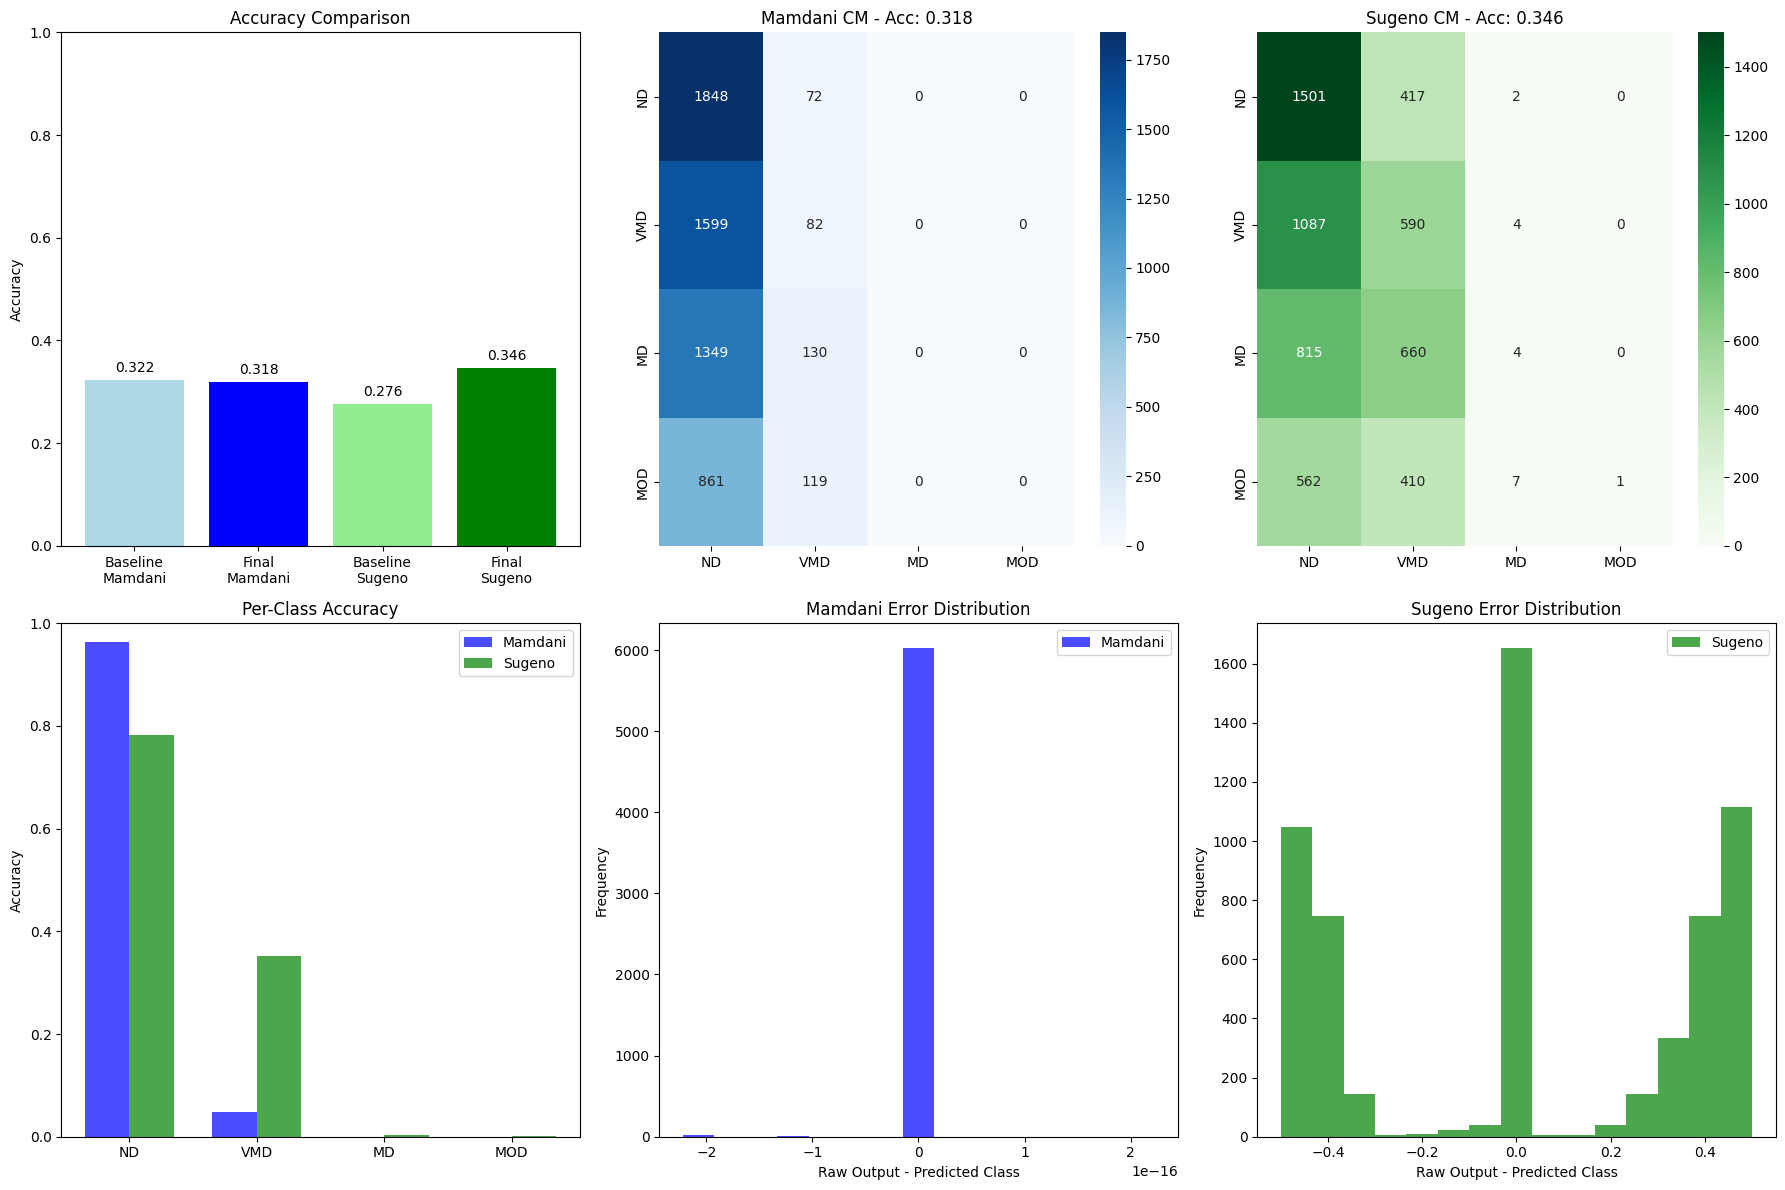


FINAL REPORT
PERFORMANCE SUMMARY:
   Total images: 40385
   Features extracted: 9 features
   Mamdani rules: 12
   Sugeno rules: 27
   Baseline Mamdani: 0.3221
   Final Mamdani:    0.3185 (-0.0036)
   Baseline Sugeno:  0.2764
   Final Sugeno:     0.3459 (+0.0695)
   Best Method: Sugeno (0.3459)
   Optimization:  Success

CLASSIFICATION REPORTS:

MAMDANI:
                  precision    recall  f1-score   support

     NonDemented       0.33      0.96      0.49      1920
VeryMildDemented       0.20      0.05      0.08      1681
    MildDemented       0.00      0.00      0.00      1479
ModerateDemented       0.00      0.00      0.00       980

        accuracy                           0.32      6060
       macro avg       0.13      0.25      0.14      6060
    weighted avg       0.16      0.32      0.18      6060


SUGENO:
                  precision    recall  f1-score   support

     NonDemented       0.38      0.78      0.51      1920
VeryMildDemented       0.28      0.35      0.31  

In [7]:
if __name__ == "__main__":
    # Sesuaikan path ke Google Drive atau local
    DATA_PATH = "/content/drive/MyDrive/RESEARCH_DATA/ALZHAIMER/data"

    if os.path.exists(DATA_PATH):
        experiment_results = run_alzheimer_experiment(
            DATA_PATH,
            limit_per_class=None,
            optimize=True
        )

        if experiment_results:
            print("\nModel")
    else:
        print(f"error")